In [1]:
import glob
exp = "12-06_17-46_twcc_con50_all_SENSE_5e-05"
gpu = 5

files = sorted(glob.glob(f"/nfs/home/leo0511/Research/SSSP/exp/SENSE/FT/{exp}/ep*"))
for file in files:
    print(f"python test_SENSE.py --model_path {file} --GPU_ID {gpu}")

python test_SENSE.py --model_path /nfs/home/leo0511/Research/SSSP/exp/SENSE/FT/12-06_17-46_twcc_con50_all_SENSE_5e-05/ep_10_iter_142000_mae_6.671_mse_8.385_seq_MAE_16.673_WRAE_38.277_MIAE_1.428_MOAE_1.422.pth --GPU_ID 5
python test_SENSE.py --model_path /nfs/home/leo0511/Research/SSSP/exp/SENSE/FT/12-06_17-46_twcc_con50_all_SENSE_5e-05/ep_10_iter_146000_mae_5.970_mse_8.089_seq_MAE_8.848_WRAE_17.820_MIAE_1.140_MOAE_1.222.pth --GPU_ID 5
python test_SENSE.py --model_path /nfs/home/leo0511/Research/SSSP/exp/SENSE/FT/12-06_17-46_twcc_con50_all_SENSE_5e-05/ep_10_iter_150000_mae_5.947_mse_7.916_seq_MAE_10.970_WRAE_25.224_MIAE_1.195_MOAE_1.195.pth --GPU_ID 5
python test_SENSE.py --model_path /nfs/home/leo0511/Research/SSSP/exp/SENSE/FT/12-06_17-46_twcc_con50_all_SENSE_5e-05/ep_11_iter_158000_mae_5.892_mse_7.933_seq_MAE_10.999_WRAE_23.962_MIAE_1.201_MOAE_1.215.pth --GPU_ID 5
python test_SENSE.py --model_path /nfs/home/leo0511/Research/SSSP/exp/SENSE/FT/12-06_17-46_twcc_con50_all_SENSE_5e-05/ep_

In [3]:
a = " "

b = ""
for aa in a:
    b += aa

len(b)

1

In [7]:
import torch 

a = torch.Tensor([[0,12,-13]])
b = torch.tensor([2])
torch.nn.functional.cross_entropy(a,b)

tensor(25.0000)

In [25]:
a = torch.Tensor([[0,torch.inf,-13]])
a.max()

tensor(inf)

In [15]:
torch.softmax(a,dim=1)

tensor([[6.1442e-06, 9.9999e-01, 1.3888e-11]])

In [16]:
torch.softmax(torch.softmax(a,dim=1),dim=1)

tensor([[0.2119, 0.5761, 0.2119]])

In [18]:
torch.softmax(torch.softmax(torch.softmax(a,dim=1),dim=1),dim=1)

tensor([[0.2908, 0.4185, 0.2908]])

In [11]:

-torch.log(torch.softmax(a,dim=1))

tensor([[1.2000e+01, 6.1989e-06, 2.5000e+01]])

In [4]:
import torch
import torch.nn.functional as F
import torch.nn as nn
data1 = torch.tensor([[[0,1,0],[2,0,0],[0,1,2]]])
data2 = torch.Tensor([[[[0,1,0],[0,0,0],[0,1,0]],[[1,0,0],[2,0,0],[0,3,2]],[[0,1,0],[0,0,4],[0,1,2]]],[[[0,1,0],[0,0,1],[0,1,2]],[[1,2,0],[2,0,0],[0,3,2]],[[0,1,0],[0,0,4],[0,1,2]]]])
data3 = torch.zeros_like(data2).squeeze()
print(data2.shape)                  
print(torch.argmax(data2,dim=1))
print(data2)
for scale in range(data3.shape[1]):
    data3[:,scale][torch.where(torch.argmax(data2,dim=1).squeeze()==scale)] = 1
print(data3)

# print(F.softmax(data2,dim=1))


# F.upsample_nearest(data1, scale_factor=2)
F.cross_entropy(data2, data1,reduction='none')


torch.Size([2, 3, 3, 3])
tensor([[[1, 0, 0],
         [1, 0, 2],
         [0, 1, 1]],

        [[1, 1, 0],
         [1, 0, 2],
         [0, 1, 0]]])
tensor([[[[0., 1., 0.],
          [0., 0., 0.],
          [0., 1., 0.]],

         [[1., 0., 0.],
          [2., 0., 0.],
          [0., 3., 2.]],

         [[0., 1., 0.],
          [0., 0., 4.],
          [0., 1., 2.]]],


        [[[0., 1., 0.],
          [0., 0., 1.],
          [0., 1., 2.]],

         [[1., 2., 0.],
          [2., 0., 0.],
          [0., 3., 2.]],

         [[0., 1., 0.],
          [0., 0., 4.],
          [0., 1., 2.]]]])
tensor([[[[0., 1., 1.],
          [0., 1., 0.],
          [1., 0., 0.]],

         [[1., 0., 0.],
          [1., 0., 0.],
          [0., 1., 1.]],

         [[0., 0., 0.],
          [0., 0., 1.],
          [0., 0., 0.]]],


        [[[0., 0., 1.],
          [0., 1., 0.],
          [1., 0., 1.]],

         [[1., 1., 0.],
          [1., 0., 0.],
          [0., 1., 0.]],

         [[0., 0., 0.],
        

ValueError: Expected input batch_size (2) to match target batch_size (1).

tensor([[[[0., 1., 0.],
          [0., 0., 1.],
          [0., 1., 2.]]],


        [[[0., 1., 0.],
          [0., 0., 1.],
          [0., 1., 2.]]],


        [[[0., 1., 0.],
          [0., 0., 1.],
          [0., 1., 2.]]]])

In [26]:
a = torch.Tensor([1,5,3])
print(F.softmax(-a))
print(F.softmax(1/a))



tensor([0.8668, 0.0159, 0.1173])
tensor([0.5095, 0.2289, 0.2616])


/tmp/ipykernel_1079881/1412361636.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  print(F.softmax(-a))
/tmp/ipykernel_1079881/1412361636.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  print(F.softmax(1/a))


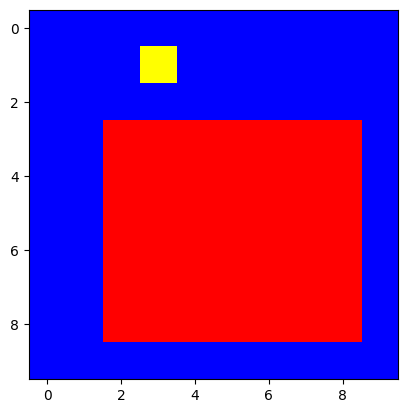

In [16]:
import matplotlib.pyplot as plt
import numpy as np
# data2 = np.reshape(LabelPred,[600,900])
import torch.nn.functional as F
import torch
import cv2


data1 = torch.zeros((1,3,10,10))
data2 = torch.zeros((1,10,10)).long()
data2[0,3:9,2:9] = 1
data2[0,1:2,3:4] = 2

F.cross_entropy(data1,data2)
COLOR_MAP = [
    [255, 0, 0],
    [0, 0, 255],
    [0, 255, 255],
]
COLOR_MAP = np.array(COLOR_MAP, dtype="uint8")


data2 = cv2.cvtColor(COLOR_MAP[np.array(data2)].squeeze(),cv2.COLOR_RGB2BGR)


plt.imshow(data2)
plt.show()

In [9]:
data1

tensor([[[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

         [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          

In [12]:
from PIL import Image
import os
import glob

paths = glob.glob("../../../datasets/HT21/train/HT21-02/img1/*")
# paths += glob.glob("../../../datasets/HT21/train/HT21-03/img1/*")
# paths += glob.glob("../../../datasets/HT21/train/HT21-04/img1/*")
# paths += glob.glob("../../../datasets/HT21/train/HT21-01/img1/*")

print(paths)

['../../../datasets/HT21/train/HT21-02/img1/002877.jpg', '../../../datasets/HT21/train/HT21-02/img1/001815.jpg', '../../../datasets/HT21/train/HT21-02/img1/000079.jpg', '../../../datasets/HT21/train/HT21-02/img1/000831.jpg', '../../../datasets/HT21/train/HT21-02/img1/002918.jpg', '../../../datasets/HT21/train/HT21-02/img1/002113.jpg', '../../../datasets/HT21/train/HT21-02/img1/001406.jpg', '../../../datasets/HT21/train/HT21-02/img1/000407.jpg', '../../../datasets/HT21/train/HT21-02/img1/000401.jpg', '../../../datasets/HT21/train/HT21-02/img1/000293.jpg', '../../../datasets/HT21/train/HT21-02/img1/002019.jpg', '../../../datasets/HT21/train/HT21-02/img1/000816.jpg', '../../../datasets/HT21/train/HT21-02/img1/001998.jpg', '../../../datasets/HT21/train/HT21-02/img1/002903.jpg', '../../../datasets/HT21/train/HT21-02/img1/000471.jpg', '../../../datasets/HT21/train/HT21-02/img1/001929.jpg', '../../../datasets/HT21/train/HT21-02/img1/001659.jpg', '../../../datasets/HT21/train/HT21-02/img1/0005

In [13]:
import torchvision.transforms as standard_transforms



img_transform = standard_transforms.Compose([
        standard_transforms.ToTensor(),
        # standard_transforms.Normalize(*([117/255., 110/255., 105/255.], [67.10/255., 65.45/255., 66.23/255.]))
        
    ])
# main_transform = train_pair_transform

In [4]:
paths = ["../../../datasets/HT21/train/HT21-02/img1/000295.jpg",
"../../../datasets/HT21/train/HT21-02/img1/002159.jpg",
"../../../datasets/HT21/train/HT21-02/img1/001932.jpg",
"../../../datasets/HT21/train/HT21-02/img1/003024.jpg",
"../../../datasets/HT21/train/HT21-02/img1/000799.jpg",
"../../../datasets/HT21/train/HT21-02/img1/001096.jpg",
"../../../datasets/HT21/train/HT21-02/img1/000355.jpg"]

In [14]:
import torch
from PIL import Image

for path in paths:
    img = Image.open(path)
    if img.mode != 'RGB':
            img=img.convert('RGB')
#     img, target = self.main_transforms(img, target)
    img = img_transform(img)

    if torch.isnan(img).any() or torch.isinf(img).any():
        print(path)